# Modelling motor insurance claim frequency


<div align="right" style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Setup

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import built-in modules
import sys
import platform
import os
from pathlib import Path
import string

# Import external modules
from IPython import __version__ as IPy_version
import IPython.display as ipyd
import numpy as np
import pandas as pd
from sklearn import __version__ as skl_version
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from bokeh import __version__ as bk_version
from scipy import __version__ as scipy_version
from statsmodels import __version__ as sm_version
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import __version__ as patsy_version

In [ ]:
# Bokeh imports
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis

# Load Bokeh for use in a notebook
from bokeh.io import output_notebook
output_notebook()

In [ ]:
# Configuration variables
claims_data_filepath = Path('./train_data.csv')
claims_data_filepath2 = Path('./test_data.csv')

## Useful functions

In [ ]:
def score_data(data_df, GLMRes_obj):
    raw_exog_names = pd.Series(GLMRes_obj.model.exog_names[1:]).str.split(
        '[', expand=True, n=1).iloc[:,0].drop_duplicates().to_list()
    scored_df = data_df.assign(
        wgt=lambda x: x.Exposure,
        act_freq=lambda x: x[GLMRes_obj.model.endog_names] / x.wgt,
        pred_freq=lambda x: GLMRes_obj.predict(x[raw_exog_names]),
        act_Nb=lambda x: x[GLMRes_obj.model.endog_names],
        pred_Nb=lambda x: x.pred_freq * x.wgt,
    )
    return(scored_df)

In [ ]:
def get_cut_grps(df, cut_by, n_bins):
    if isinstance(n_bins, int):
        return(pd.cut(df[cut_by], bins=n_bins))
    if n_bins == 'cat':
        return(df[cut_by])
    if n_bins == 'all':
        bins = np.sort(df[cut_by].unique())
        offset = np.min(np.diff(bins)) / 2
        bins = np.insert(bins, 0, 2*bins[0] - bins[1]) + offset
        return(pd.cut(df[cut_by], bins=bins))

In [ ]:
def get_agg_plot_data(data_df,order_by = None,cut_by = None,x_axis_var = None,n_bins = None,set_config = None):
    # Set defaults
    if set_config == "lift":
        if order_by is None:
            order_by = 'pred_freq'
        if cut_by is None:
            cut_by = 'cum_wgt'
        if x_axis_var is None:
            x_axis_var = cut_by
        if n_bins is None:
            n_bins = 10
    if cut_by is None:
        cut_by = order_by
    if x_axis_var is None:
        x_axis_var = cut_by

    plt_data_df = data_df\
    .rename_axis(index='index').sort_values([order_by, 'index']).assign(
        cum_wgt_raw=lambda x: x.wgt.cumsum(),
        cum_wgt=lambda x: x.groupby(order_by).cum_wgt_raw.transform('max'),
        grp=lambda df: get_cut_grps(df, cut_by, n_bins)
    ).groupby('grp', sort=False).agg(
        n_obs=('grp', 'size'), 
        wgt_sum=('wgt', 'sum'),
        act_Nb=('act_Nb', 'sum'),
        pred_Nb=('pred_Nb', 'sum'),
        x_min=(x_axis_var, 'min'),
        x_max=(x_axis_var, 'max'),
    ).pipe(lambda x: (
        x.reset_index(drop=True).pipe(lambda x: (
            x.set_index(pd.interval_range(start=-0.5, periods=x.shape[0], freq=1.))
        )) if n_bins == 'cat' 
        else x.set_index(x.index.categories)
    )).assign(
        act_av=lambda x: x.act_Nb / x.wgt_sum,
        pred_av=lambda x: x.pred_Nb / x.wgt_sum,
        x_left=lambda x: np.select(
            [x.x_min == x.x_max],
            [x.index.left], 
            default=x.x_min
        ),
        x_right=lambda x: np.select(
            [x.x_min == x.x_max],
            [x.index.right],
            default=x.x_max
        ),
        x_mid=lambda x: (x.x_right + x.x_left) / 2,
    )
    return(plt_data_df)

In [8]:
def create_plot(plt_data_df, n_bins = None):
    bkplt = figure(
        title="Predicted vs Actual chart", x_axis_label='Pred val', y_axis_label="Exposure", 
        tools="reset,box_zoom,pan,wheel_zoom,save", background_fill_color="#fafafa",
        plot_width=800, plot_height=500
    )
    bkplt.quad(
        top=plt_data_df.wgt_sum, bottom=0, left=plt_data_df.x_left, right=plt_data_df.x_right,
        fill_color="khaki", line_color="white", legend_label="Exposure"
    )
    bkplt.y_range=Range1d(0, plt_data_df.wgt_sum.max() / 0.5)

    y_range2_name = 'y_range2_name'
    bkplt.extra_y_ranges[y_range2_name] = Range1d(
        plt_data_df[['act_av', 'pred_av']].min().min(), 
        plt_data_df[['act_av', 'pred_av']].max().max() / 0.9
    )
    ax_new = LinearAxis(y_range_name=y_range2_name, axis_label="Average response")
    bkplt.add_layout(ax_new, 'right')

    for col_name, color in [('pred_av', 'purple'), ('act_av', 'green')]:
        bkplt.circle(
            plt_data_df.x_mid, plt_data_df[col_name], 
            color=color, size=4,
            y_range_name=y_range2_name,
            legend_label=col_name
        )
        bkplt.line(
            plt_data_df.x_mid, plt_data_df[col_name], 
            color=color, # size=4,
            y_range_name=y_range2_name,
            legend_label=col_name
        )

    bkplt.grid.grid_line_color = "white"
    bkplt.legend.location = "top_left"
    bkplt.legend.click_policy="hide"

    if n_bins == "cat":
        x_tick_labs = plt_data_df.x_min.astype(str).reset_index(drop=True).to_dict()
        bkplt.xaxis.ticker = list(x_tick_labs.keys())
        bkplt.xaxis.major_label_overrides = x_tick_labs
    
    return(bkplt)

In [9]:
def get_cat_map_ordered(df, cat_col_name, order_by='act_av_freq'):
    res = df.groupby(cat_col_name).agg(
        n_obs=(cat_col_name, 'size'),
        wgt_sum=('Exposure', 'sum'),
        act_Nb=('ClaimNb', 'sum'),
    ).assign(
        act_av_freq=lambda x: x.act_Nb / x.wgt_sum
    ).sort_values(
        [order_by], ascending=False
    ).assign(
        all_levels=lambda x: x.reset_index().index
    )
    return(res)

In [10]:
def agg_act_pred(df,by_col,type):
    if by_col=='Date':
        df['YM']=pd.to_datetime(df.Date).dt.to_period('M')
        by_col='YM'
    if type=='S':
        d=pd.DataFrame(df.groupby(by=[by_col]).agg({'payout':'sum','wgt':'sum','pred_sev':'mean'})).reset_index()
        d['Act_sev']=d['payout']/d['wgt']
        d.rename(columns={'payout':'pay_sum'},inplace=True)
        e=pd.DataFrame(df.groupby(by=[by_col]).agg({'payout':'mean'})).reset_index()
        e.rename(columns={'payout':'pay_mean'},inplace=True)
        d=pd.merge(d,e,on=[by_col],how='left')
        del e
    if type=='F':
        d=pd.DataFrame(df.groupby(by=[by_col]).agg({'ClaimNb':'sum','wgt':'sum','pred_freq':'mean','Actual_premium':'mean'})).reset_index()
        d['Act_freq']=d['ClaimNb']/d['wgt']
        
    return d

In [12]:
def get_df_extra(df):
    """
    Given a DataFrame of that contains the raw data columns (and possibly additional columns), 
    return the DataFrame with additional pre-processed columns
    """
    df_extra = df.copy()
    
    # Calculate frequency per year on each row
    df_extra['Frequency'] = df_extra['ClaimNb'] / df_extra['Exposure']
    # Calculate severity per year on each row
    df_extra['severity'] = df_extra['payout'] / df_extra['ClaimNb']
    # adding the month field
    df_extra['Month'] = pd.to_datetime(df_extra.Date,format='%Y-%m-%d').dt.month
    
    
    # Feature engineering (the results of the analysis below)
    VehBrand_map_sers = pd.Series({
        'B12': 'X', 'B14': 'X', 'B13': 'X',
        'B3': 'X', 'B11': 'X','B4': 'X', 'B5': 'X',
        'B1': 'Y', 'B6': 'Y',
        'B2': 'Z', 'B10': 'Z'
    })

    Region_map_sers = pd.Series({
        **{reg: 'W' for reg in ['R21', 'R94', 'R11', 'R42', 'R22', 'R74']},
        **{reg: 'X' for reg in ['R91', 'R82']},
        **{reg: 'Y' for reg in ['R93', 'R53']},
        **{reg: 'Z' for reg in ['R26', 'R25', 'R52', 'R31', 'R54', 'R73', 
                                'R23', 'R72', 'R83', 'R41', 'R43']},
        **{reg: 'A' for reg in ['R24']},
    })

    df_extra = df_extra.assign(
        DrivAge_capped=lambda x: np.clip(x.DrivAge, None, 80),
        DrivAge_pow2=lambda x: np.power(x.DrivAge_capped, 2),
        BonusMalus_over_50=lambda x: np.select([x.BonusMalus > 50], ["Y"], default="N"),
        BonusMalus_mod3=lambda x: np.floor((np.clip(x.BonusMalus, None, 90) - 48)/3)*3 + 50,
        VehAge_new=lambda x: np.select([x.VehAge == 0], ["Y"], default="N"),
        VehAge_capped=lambda x: np.clip(x.VehAge, None, 18),
        VehBrand_grd=lambda x: VehBrand_map_sers.loc[x.VehBrand].values,
        Density_log=lambda x: np.log10(np.clip(x.Density, 10, np.power(10, 4))),
        Region_grd=lambda x: Region_map_sers.loc[x.Region].values,
    )
    
    return(df_extra)  

<div align="right" style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Modelling data

## Load data

In [13]:
# Load full data set
df_raw = pd.read_csv(claims_data_filepath, delimiter=',')
df_raw1 = pd.read_csv(claims_data_filepath2, delimiter=',')
print(df_raw.shape)
print(df_raw1.shape)

(488507, 16)
(86208, 16)


In [14]:
df_raw.isna().sum()

IDpol             0
ClaimNb           0
Exposure          0
Area              0
VehPower          0
VehAge            0
DrivAge           0
BonusMalus        0
VehBrand          0
VehGas            0
Density           0
Region            0
Date              0
payout            0
Actual_premium    0
YM                0
dtype: int64

In [15]:
# Check it has loaded OK
nRows, nCols = (488507, 16)
assert df_raw.shape == (nRows, nCols)
print(f"Correct: Shape of DataFrame is as expected: {nRows} rows, {nCols} cols")

Correct: Shape of DataFrame is as expected: 488507 rows, 16 cols


## Pre-processing

In [16]:
# Run pre-processing to get a new DataFrame
df_extra = get_df_extra(df_raw)
# Run pre-processing to get a new DataFrame
df_extra1 = get_df_extra(df_raw1)

<div align="right" style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Modelling setup

In [17]:
df_train_mod=df_extra.copy()
del df_extra
df_test_mod=df_extra1.copy()
del df_extra1
print("Train sample size: " + str(df_train_mod.shape))

print("Test sample size: " + str(df_test_mod.shape))

Train sample size: (488507, 28)
Test sample size: (86208, 28)


In [18]:
expl_var_names = [
    col_name for col_name in df_train_mod.columns.to_list() 
     if col_name not in ['IDpol', 'ClaimNb', 'Exposure', 'Frequency','Date','payout','Actual_premium','severity',
                         'VehAge','DrivAge','BonusMalus','VehBrand','YM']
]
print("Explanatory variables\n" + '\t'.join(expl_var_names))
simple_features = ['Area','VehPower','VehAge','DrivAge','BonusMalus','VehBrand','VehGas','Density','Region','Month']
print("\nOf which the following are simple features\n" + '\t'.join(simple_features))

Explanatory variables
Area	VehPower	VehGas	Density	Region	Month	DrivAge_capped	DrivAge_pow2	BonusMalus_over_50	BonusMalus_mod3	VehAge_new	VehAge_capped	VehBrand_grd	Density_log	Region_grd

Of which the following are simple features
Area	VehPower	VehAge	DrivAge	BonusMalus	VehBrand	VehGas	Density	Region	Month


In [19]:
# Initialise DataFrame for holding model info
mods_df = pd.DataFrame(np.empty(0, dtype=np.dtype([
    ('mod_name', np.dtype('O')),
    ('descr', np.dtype('O')),
    ('GLMResults', np.dtype('O')),
])))

# Dictionary of scores on the data
scored_dfs = dict()

# Fit and score -Simple features

In [ ]:
# %%time
# # Takes approx 20 secs
# mods_df.loc[0, ['mod_name', 'descr']] = [ 'All_simple_features', 'All simple features']
# mods_df.GLMResults[0] = smf.glm(
#     "ClaimNb ~ " +  ' + '.join(simple_features),
#     data=df_train_mod, exposure=np.asarray(df_train_mod['Exposure']),
#     family=sm.families.Poisson(sm.genmod.families.links.log()),
# ).fit()
# print(mods_df.GLMResults[0].summary())

# # save the model results
# file = open('GLM_summary_freq_simple.txt', 'w')
# file.write(str(mods_df.GLMResults[0].summary()))
# file.close()

In [ ]:
# %%time
# # Score all the training data for analysis
# scored_dfs[0] = score_data(df_train_mod, mods_df.GLMResults[0])

# # Reasonableness checks
# assert np.abs(scored_dfs[0].act_Nb.sum() - df_train_mod.ClaimNb.sum()) < 1e-7
# assert np.abs(scored_dfs[0].wgt.sum() - df_train_mod.Exposure.sum()) < 1e-7
# print("Correct: Reasonableness checks pass\n")
# print(f"Predicted number of claims:\t{scored_dfs[0].pred_Nb.sum():,.1f}")
# print(f"Actual number of claims:\t{scored_dfs[0].ClaimNb.sum():,.1f}")
# print(f"Difference:\t\t\t{scored_dfs[0].pred_Nb.sum() - scored_dfs[0].ClaimNb.sum():,.1f}")

## Lift chart & test validation 

### Model0

In [ ]:
# # Sample data for visualisations
# df_extra_for_plt = score_data(df_test_mod, mods_df.GLMResults[0])
# lift_plt_data_df = get_agg_plot_data(df_extra_for_plt, set_config = "lift")
# lift_plt = create_plot(lift_plt_data_df)
# show(lift_plt)

# lift_actuals = lift_plt_data_df.act_av.iloc[-1] / lift_plt_data_df.act_av.iloc[0]
# lift_pred = lift_plt_data_df.pred_av.iloc[-1] / lift_plt_data_df.pred_av.iloc[0]
# print(f'Lift on actuals:\t{lift_actuals:.3f}')
# print(f'Lift on predicted:\t{lift_pred:.3f}')

# # test validation over time
# # read test
# df_test=pd.read_csv('./test_data.csv')
# print(df_test.shape)
# # data prep
# df_test = get_df_extra(df_test)
# print(df_test.shape)
# # score
# a=score_data(df_test, mods_df.GLMResults[0])
# # summary
# a=agg_act_pred(a,'YM','F')
# plt.figure(figsize=(15,9))
# plt.ylim(.08,.12)
# plt.grid()
# plt.plot(a.YM,a.Act_freq,color='r',label='Actual Frequency')
# plt.plot(a.YM,a.pred_freq,color='b',label='Predicted Frequency')
# plt.legend()

# Feature selection
Try selecting simple factors in stepwise regression using AIC. We want to minimise the AIC.

## simple features

In [ ]:
# # The modelling is quite intensive on memory,
# # so we need to limit the amount of data used
# _, data_swreg_df = train_test_split(df_train_mod,
#                                     test_size=0.5,
#                                     random_state=98,
#                                     shuffle=True)

In [ ]:
# def fit_candidate(
#         selected,
#         candidate,
#         n_step,
#         n_iter,  # Adds these values to the model list
#         mods_swreg_df,  # Add results to this model list
#         data_swreg_df,  # Use this data set
#         direction=None,
#         verbose=True):
#     """Fit a model with an additional 'candidate' factor"""
#     if direction is None:
#         direction = 'fwd'

#     if direction == 'fwd':
#         if candidate is "None":
#             factors_ls = selected
#         else:
#             factors_ls = selected + [candidate]
#     else:
#         factors_ls = selected.copy()
#         if candidate is not "None":
#             factors_ls.remove(candidate)

#     mods_swreg_df.loc[n_iter, ['step', 'candidate', 'rhs_str']] = [
#         n_step, candidate, ' + '.join(['1'] + factors_ls)
#     ]

#     GLMRes_tmp = smf.glm(
#         "ClaimNb ~ " + mods_swreg_df.loc[n_iter, 'rhs_str'],
#         data=data_swreg_df,
#         exposure=np.asarray(data_swreg_df['Exposure']),
#         family=sm.families.Poisson(sm.genmod.families.links.log()),
#     ).fit()

#     mods_swreg_df.loc[n_iter, 'aic'] = GLMRes_tmp.aic
#     mods_swreg_df.loc[n_iter, 'df_model'] = GLMRes_tmp.df_model
#     GLMRes_tmp.remove_data()  # Clear up to save RAM
#     mods_swreg_df.loc[n_iter, 'GLMResults'] = GLMRes_tmp

#     if verbose:
#         print(f"Iter: {n_iter:<2}\t"
#               f"Candidate: {candidate:<10}\t"
#               f"AIC: {mods_swreg_df.loc[n_iter, 'aic']:.1f}")

#     return (mods_swreg_df)

In [ ]:
# # Initialise DataFrame for holding model info
# mods_swreg_df = pd.DataFrame(
#     np.empty(int(0),
#              dtype=np.dtype([
#                  ('step', np.dtype('int64')),
#                  ('candidate', np.dtype('O')),
#                  ('rhs_str', np.dtype('O')),
#                  ('GLMResults', np.dtype('O')),
#                  ('df_model', np.dtype('int64')),
#                  ('aic', np.dtype('float64')),
#              ])))

# n_iter = 0
# n_step = 0
# remaining = simple_features.copy()
# direction = 'fwd'
# if direction == 'fwd':
#     selected = []
# else:
#     selected = remaining.copy()
# go_to_next_step = True

In [ ]:
# run_this_chunk = True
# if run_this_chunk:

#     # The below loop does not cover the initial model
#     # Takes approx 4 mins
#     mods_swreg_df = fit_candidate(selected=selected,
#                                   candidate="None",
#                                   n_step=n_step,
#                                   n_iter=n_iter,
#                                   mods_swreg_df=mods_swreg_df,
#                                   data_swreg_df=data_swreg_df,
#                                   direction=direction,
#                                   verbose=True)

#     while remaining and go_to_next_step:
#         n_step += 1
#         go_to_next_step = False
#         print(f"==== Step {n_step:02} ====\n"
#               f"Already selected: {', '.join(selected)}\n"
#               f"Remaining: {', '.join(remaining)}")

#         for candidate in remaining:
#             n_iter += 1
#             mods_swreg_df = fit_candidate(selected,
#                                           candidate,
#                                           n_step,
#                                           n_iter,
#                                           mods_swreg_df,
#                                           data_swreg_df,
#                                           direction=direction,
#                                           verbose=True)

#         mods_swreg_df = mods_swreg_df.sort_values(['step', 'aic', 'rhs_str'
#                                                    ]).reset_index(drop=True)
#         best_aic_so_far = mods_swreg_df.aic.min()
#         best_in_step = mods_swreg_df.query(f"step == {n_step}")[[
#             'candidate', 'aic'
#         ]].iloc[0]

#         if best_in_step.aic == best_aic_so_far:
#             if direction == 'fwd':
#                 selected.append(best_in_step.candidate)
#             else:
#                 selected.remove(best_in_step.candidate)
#             remaining.remove(best_in_step.candidate)
#             print(f"Step {n_step:02} "
#                   f"selected: {best_in_step.candidate:<10} "
#                   f"(AIC: {best_in_step.aic:.1f})")
#             go_to_next_step = True
#         else:
#             print(f"Step {n_step:02} "
#                   f"selected: None\n"
#                   f"==== Stepwise regression complete ====")

In [ ]:
# # Save and view results
# if run_this_chunk:
#     mods_fw_swreg_df = mods_swreg_df.copy()
#     best_mod = mods_fw_swreg_df.query(
#         "aic == @mods_fw_swreg_df.aic.min()").iloc[0]
#     print("Best model for forward regression:")
#     print("-" * 40)
#     print("Formula:\t" + best_mod.rhs_str + "\n"
#           f"aic:\t\t{best_mod.aic:.2f}\n"
#           f"df_model:\t{int(best_mod.df_model)}")

## extra features

In [ ]:
# # The modelling is quite intensive on memory,
# # so we need to limit the amount of data used
# _, data_swreg_df = train_test_split(df_train_mod,
#                                     test_size=0.5,
#                                     random_state=98,
#                                     shuffle=True)

In [ ]:
# def fit_candidate(
#         selected,
#         candidate,
#         n_step,
#         n_iter,  # Adds these values to the model list
#         mods_swreg_df,  # Add results to this model list
#         data_swreg_df,  # Use this data set
#         direction=None,
#         verbose=True):
#     """Fit a model with an additional 'candidate' factor"""
#     if direction is None:
#         direction = 'fwd'

#     if direction == 'fwd':
#         if candidate is "None":
#             factors_ls = selected
#         else:
#             factors_ls = selected + [candidate]
#     else:
#         factors_ls = selected.copy()
#         if candidate is not "None":
#             factors_ls.remove(candidate)

#     mods_swreg_df.loc[n_iter, ['step', 'candidate', 'rhs_str']] = [
#         n_step, candidate, ' + '.join(['1'] + factors_ls)
#     ]

#     GLMRes_tmp = smf.glm(
#         "ClaimNb ~ " + mods_swreg_df.loc[n_iter, 'rhs_str'],
#         data=data_swreg_df,
#         exposure=np.asarray(data_swreg_df['Exposure']),
#         family=sm.families.Poisson(sm.genmod.families.links.log()),
#     ).fit()

#     mods_swreg_df.loc[n_iter, 'aic'] = GLMRes_tmp.aic
#     mods_swreg_df.loc[n_iter, 'df_model'] = GLMRes_tmp.df_model
#     GLMRes_tmp.remove_data()  # Clear up to save RAM
#     mods_swreg_df.loc[n_iter, 'GLMResults'] = GLMRes_tmp

#     if verbose:
#         print(f"Iter: {n_iter:<2}\t"
#               f"Candidate: {candidate:<10}\t"
#               f"AIC: {mods_swreg_df.loc[n_iter, 'aic']:.1f}")

#     return (mods_swreg_df)

In [ ]:
# # Initialise DataFrame for holding model info
# mods_swreg_df = pd.DataFrame(
#     np.empty(int(0),
#              dtype=np.dtype([
#                  ('step', np.dtype('int64')),
#                  ('candidate', np.dtype('O')),
#                  ('rhs_str', np.dtype('O')),
#                  ('GLMResults', np.dtype('O')),
#                  ('df_model', np.dtype('int64')),
#                  ('aic', np.dtype('float64')),
#              ])))

# n_iter = 0
# n_step = 0
# remaining = expl_var_names.copy()
# direction = 'fwd'
# if direction == 'fwd':
#     selected = []
# else:
#     selected = remaining.copy()
# go_to_next_step = True

In [ ]:
# run_this_chunk = True
# if run_this_chunk:

#     # The below loop does not cover the initial model
#     # Takes approx 4 mins
#     mods_swreg_df = fit_candidate(selected=selected,
#                                   candidate="None",
#                                   n_step=n_step,
#                                   n_iter=n_iter,
#                                   mods_swreg_df=mods_swreg_df,
#                                   data_swreg_df=data_swreg_df,
#                                   direction=direction,
#                                   verbose=True)

#     while remaining and go_to_next_step:
#         n_step += 1
#         go_to_next_step = False
#         print(f"==== Step {n_step:02} ====\n"
#               f"Already selected: {', '.join(selected)}\n"
#               f"Remaining: {', '.join(remaining)}")

#         for candidate in remaining:
#             n_iter += 1
#             mods_swreg_df = fit_candidate(selected,
#                                           candidate,
#                                           n_step,
#                                           n_iter,
#                                           mods_swreg_df,
#                                           data_swreg_df,
#                                           direction=direction,
#                                           verbose=True)

#         mods_swreg_df = mods_swreg_df.sort_values(['step', 'aic', 'rhs_str'
#                                                    ]).reset_index(drop=True)
#         best_aic_so_far = mods_swreg_df.aic.min()
#         best_in_step = mods_swreg_df.query(f"step == {n_step}")[[
#             'candidate', 'aic'
#         ]].iloc[0]

#         if best_in_step.aic == best_aic_so_far:
#             if direction == 'fwd':
#                 selected.append(best_in_step.candidate)
#             else:
#                 selected.remove(best_in_step.candidate)
#             remaining.remove(best_in_step.candidate)
#             print(f"Step {n_step:02} "
#                   f"selected: {best_in_step.candidate:<10} "
#                   f"(AIC: {best_in_step.aic:.1f})")
#             go_to_next_step = True
#         else:
#             print(f"Step {n_step:02} "
#                   f"selected: None\n"
#                   f"==== Stepwise regression complete ====")

In [ ]:
# # Save and view results
# if run_this_chunk:
#     mods_fw_swreg_df = mods_swreg_df.copy()
#     best_mod = mods_fw_swreg_df.query(
#         "aic == @mods_fw_swreg_df.aic.min()").iloc[0]
#     print("Best model for forward regression:")
#     print("-" * 40)
#     print("Formula:\t" + best_mod.rhs_str + "\n"
#           f"aic:\t\t{best_mod.aic:.2f}\n"
#           f"df_model:\t{int(best_mod.df_model)}")

# Fit and score -selected features

In [ ]:
# print(expl_var_names)

# # fit model
# mods_df.loc[1, ['mod_name', 'descr']] = ['All_simple_features', 'All simple features']
# mods_df.GLMResults[1] = smf.glm(
#     "ClaimNb ~ " +  ' + '.join(expl_var_names),
#     data=df_train_mod, exposure=np.asarray(df_train_mod['Exposure']),
#     family=sm.families.Poisson(sm.genmod.families.links.log()),
# ).fit()
# print(mods_df.GLMResults[1].summary())

# # save the model results
# file = open('GLM_summary_freq_EF.txt', 'w')
# file.write(str(mods_df.GLMResults[1].summary()))
# file.close()

In [ ]:
# SF1 = ['DrivAge_capped', 'DrivAge_pow2', 'BonusMalus_over_50', 'BonusMalus_mod3', 'VehAge_new', 'VehAge_capped', 
#        'VehBrand_grd', 'Density_log', 'Region_grd', 'Month', 'VehPower', 'VehGas']

# # fit model
# mods_df.loc[2, ['mod_name', 'descr']] = [ 'All_simple_features',  'All simple features']
# mods_df.GLMResults[2] = smf.glm(
#     "ClaimNb ~ " +  ' + '.join(SF1),
#     data=df_train_mod, exposure=np.asarray(df_train_mod['Exposure']),
#     family=sm.families.Poisson(sm.genmod.families.links.log()),
# ).fit()
# print(mods_df.GLMResults[2].summary())

# # save the model results
# file = open('GLM_summary_freq_SF1.txt', 'w')
# file.write(str(mods_df.GLMResults[2].summary()))
# file.close()

In [20]:
SF2 = ['DrivAge_capped', 'DrivAge_pow2', 'BonusMalus_over_50', 'BonusMalus_mod3', 'VehAge_new', 'VehAge_capped', 
        'Density_log', 'Region_grd', 'Month', 'VehGas']

# fit model
mods_df.loc[3, ['mod_name', 'descr']] = [ 'All_simple_features',     'All simple features']
mods_df.GLMResults[3] = smf.glm(
    "ClaimNb ~ " +  ' + '.join(SF2),
    data=df_train_mod, exposure=np.asarray(df_train_mod['Exposure']),
    family=sm.families.Poisson(sm.genmod.families.links.log()),
).fit()
print(mods_df.GLMResults[3].summary())

# save the model results
file = open('GLM_summary_freq_SF2.txt', 'w')
file.write(str(mods_df.GLMResults[3].summary()))
file.close()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               488507
Model:                            GLM   Df Residuals:                   488493
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0128e+05
Date:                Tue, 02 Feb 2021   Deviance:                   1.5319e+05
Time:                        21:14:40   Pearson chi2:                 1.15e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Lift plot & test validation

### Model1

In [22]:
# # Sample data for visualisations
# df_extra_for_plt = score_data(df_test_mod, mods_df.GLMResults[1])
# lift_plt_data_df = get_agg_plot_data(df_extra_for_plt, set_config = "lift")
# lift_plt = create_plot(lift_plt_data_df)
# show(lift_plt)

# lift_actuals = lift_plt_data_df.act_av.iloc[-1] / lift_plt_data_df.act_av.iloc[0]
# lift_pred = lift_plt_data_df.pred_av.iloc[-1] / lift_plt_data_df.pred_av.iloc[0]
# print(f'Lift on actuals:\t{lift_actuals:.3f}')
# print(f'Lift on predicted:\t{lift_pred:.3f}')

# # test validation over time
# # read test
# df_test=pd.read_csv('./test_data.csv')
# print(df_test.shape)
# # data prep
# df_test = get_df_extra(df_test)
# print(df_test.shape)
# # score
# a=score_data(df_test, mods_df.GLMResults[1])
# # summary
# a=agg_act_pred(a,'YM','F')
# plt.figure(figsize=(15,9))
# plt.ylim(.08,.12)
# plt.grid()
# plt.plot(a.YM,a.Act_freq,color='r',label='Actual Frequency')
# plt.plot(a.YM,a.pred_freq,color='b',label='Predicted Frequency')
# plt.legend()

### Model2

In [ ]:
# # Sample data for visualisations
# df_extra_for_plt = score_data(df_test_mod, mods_df.GLMResults[2])
# lift_plt_data_df = get_agg_plot_data(df_extra_for_plt, set_config = "lift")
# lift_plt = create_plot(lift_plt_data_df)
# show(lift_plt)

# lift_actuals = lift_plt_data_df.act_av.iloc[-1] / lift_plt_data_df.act_av.iloc[0]
# lift_pred = lift_plt_data_df.pred_av.iloc[-1] / lift_plt_data_df.pred_av.iloc[0]
# print(f'Lift on actuals:\t{lift_actuals:.3f}')
# print(f'Lift on predicted:\t{lift_pred:.3f}')

# # test validation over time
# # read test
# df_test=pd.read_csv('./test_data.csv')
# print(df_test.shape)
# # data prep
# df_test = get_df_extra(df_test)
# print(df_test.shape)
# # score
# a=score_data(df_test, mods_df.GLMResults[2])
# # summary
# a=agg_act_pred(a,'YM','F')
# plt.figure(figsize=(15,9))
# plt.ylim(.08,.12)
# plt.grid()
# plt.plot(a.YM,a.Act_freq,color='r',label='Actual Frequency')
# plt.plot(a.YM,a.pred_freq,color='b',label='Predicted Frequency')
# plt.legend()

### Model3

Lift on actuals:	4.296
Lift on predicted:	4.580
(86208, 16)
(86208, 28)


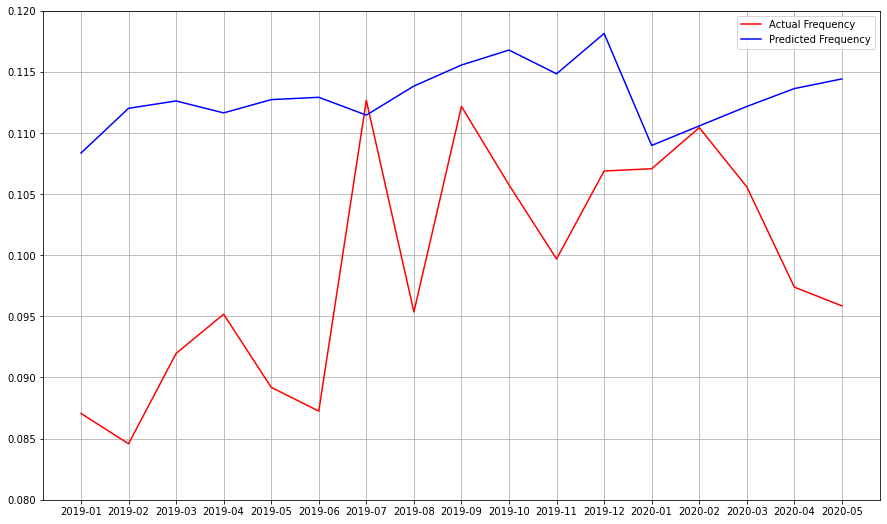

In [23]:
# Sample data for visualisations
df_extra_for_plt = score_data(df_test_mod, mods_df.GLMResults[3])
lift_plt_data_df = get_agg_plot_data(df_extra_for_plt, set_config = "lift")
lift_plt = create_plot(lift_plt_data_df)
show(lift_plt)

lift_actuals = lift_plt_data_df.act_av.iloc[-1] / lift_plt_data_df.act_av.iloc[0]
lift_pred = lift_plt_data_df.pred_av.iloc[-1] / lift_plt_data_df.pred_av.iloc[0]
print(f'Lift on actuals:\t{lift_actuals:.3f}')
print(f'Lift on predicted:\t{lift_pred:.3f}')

# test validation over time
# read test
df_test=pd.read_csv('./test_data.csv')
print(df_test.shape)
# data prep
df_test = get_df_extra(df_test)
print(df_test.shape)
# score
a=score_data(df_test, mods_df.GLMResults[3])
# summary
a=agg_act_pred(a,'YM','F')
plt.figure(figsize=(15,9))
plt.ylim(.08,.12)
plt.grid()
plt.plot(a.YM,a.Act_freq,color='r',label='Actual Frequency')
plt.plot(a.YM,a.pred_freq,color='b',label='Predicted Frequency')
plt.legend()

<div align="right" style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Output results

## Output model

In [24]:
mods_df.GLMResults[3].save("GLM_Claim_Freq_Model.pkl")

## predictions on train,test,holdout

In [25]:
df_holdout=pd.read_csv('./holdout_data.csv')
print(df_holdout.shape)
df_train=pd.read_csv('./train_data.csv')
print(df_train.shape)
df_test=pd.read_csv('./test_data.csv')
print(df_test.shape)

# data prep
df_holdout = get_df_extra(df_holdout)
df_train = get_df_extra(df_train)
df_test = get_df_extra(df_test)

a=score_data(df_train, mods_df.GLMResults[3])
b=score_data(df_test, mods_df.GLMResults[3])
c=score_data(df_holdout, mods_df.GLMResults[3])
a=pd.concat([a,b,c])
a=a[['IDpol','pred_freq','pred_Nb']]
a.to_csv('GLM_predictions_freq.csv',index=False)

(101421, 16)
(488507, 16)
(86208, 16)


# getting the summary for each feature for test

In [26]:
a=score_data(df_test, mods_df.GLMResults[3])
data=pd.DataFrame()
for i in ['DrivAge_capped', 'DrivAge_pow2', 'BonusMalus_over_50', 'BonusMalus_mod3', 'VehAge_new', 'VehAge_capped', 
        'Density_log', 'Region_grd', 'Month', 'VehGas']:    
    x=agg_act_pred(a,i,'F')
    x['feature']=i
    x.rename(columns={i:'Values'},inplace=True)
#     print(x)
    data=data.append(x)

data.to_csv('test_aggregated_var_df_freq.csv')

# getting the summary for each feature for holdout

In [27]:
a=score_data(df_holdout, mods_df.GLMResults[3])
data=pd.DataFrame()
for i in ['DrivAge_capped', 'DrivAge_pow2', 'BonusMalus_over_50', 'BonusMalus_mod3', 'VehAge_new', 'VehAge_capped', 
        'Density_log', 'Region_grd', 'Month', 'VehGas']:    
    x=agg_act_pred(a,i,'F')
    x['feature']=i
    x.rename(columns={i:'Values'},inplace=True)
#     print(x)
    data=data.append(x)

data.to_csv('holdout_aggregated_var_df_freq.csv')

# Graph

In [ ]:
# import seaborn as sns
# import pylab 
# import scipy.stats as stats

In [ ]:
# # residual plot
# a=score_data(df_holdout, mods_df.GLMResults[3])
# a=a.loc[~(a.ClaimNb==0),:]
# g=sns.residplot(x=a.pred_freq, y=a.act_freq-a.pred_freq, lowess=True, color="g")
# # g.set_ylim(-15, 15)

In [ ]:
# a=score_data(df_test, mods_df.GLMResults[3])
# sns.residplot(x=a.pred_freq, y=a.act_freq-a.pred_freq, lowess=True, color="b")

In [ ]:
# # probability Plot test
# a=score_data(df_test, mods_df.GLMResults[3])
# stats.probplot(a.pred_freq, dist="norm", plot=pylab)
# pylab.show()

In [ ]:
# # probability Plot test
# a=score_data(df_holdout, mods_df.GLMResults[3])
# stats.probplot(a.pred_freq, dist="norm", plot=pylab)
# pylab.show()

# RMSE

In [ ]:
# from sklearn.metrics import mean_squared_error

In [ ]:
# def RMSE_agg(df,model):
#     a=score_data(df, model)
#     a['YM']=pd.to_datetime(a.Date).dt.to_period('M')
#     itr_list=list(a.YM.unique())
#     b=pd.DataFrame()
#     for i in itr_list:
#         x=a.loc[a['YM']==i,:]    
#         x['RMSE']=np.sqrt(mean_squared_error(x.act_freq, x.pred_freq))
#         x=pd.DataFrame(x.groupby(by=['YM']).agg({'RMSE':'max'})).reset_index()
#         b=b.append(x)
#     return b

In [ ]:
# a=RMSE_agg(df_test, mods_df.GLMResults[3])
# b=RMSE_agg(df_train, mods_df.GLMResults[3])
# a=a.merge(b,on='YM')
# a.columns=['YM','RMSE_test','RMSE_train']
# a.to_csv('RMSE_over_month_test_train_freq.csv',index=False)

In [ ]:
# a=RMSE_agg(df_holdout, mods_df.GLMResults[3])
# a.columns=['YM','RMSE_holdout']
# a.to_csv('RMSE_over_month_holdout_freq.csv',index=False)